In [1]:
import pandas as pd
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

**1.Association Rule Generation from Transaction Data**

In [2]:
data = pd.read_csv('/kaggle/input/dataset/Grocery_Items_14.csv')

In [3]:
Transaction = []
for i in range(data.shape[0]):
    Transaction.append([str(data.values[i,j]) for j in range(data.shape[1]) if str(data.values[i,j]) != 'nan'])

In [4]:
te = TransactionEncoder()
te_ary = te.fit(Transaction).transform(Transaction)
df = pd.DataFrame(te_ary, columns=te.columns_)

**(C)**

In [5]:
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

In [6]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(soda),(other vegetables),0.097250,0.121250,0.010250,0.105398,0.869266,-0.001542,0.982281,-0.142807
1,(other vegetables),(whole milk),0.121250,0.157875,0.014625,0.120619,0.764013,-0.004517,0.957633,-0.260080
2,(rolls/buns),(whole milk),0.109625,0.157875,0.014500,0.132269,0.837809,-0.002807,0.970491,-0.178594
3,(soda),(whole milk),0.097250,0.157875,0.011125,0.114396,0.724598,-0.004228,0.950905,-0.296280
4,(yogurt),(whole milk),0.085750,0.157875,0.011625,0.135569,0.858708,-0.001913,0.974195,-0.152523


**(D)**

In [7]:
msv = [0.001,0.005,0.01,0.05]

mct = [0.05,0.075,0.1]

In [8]:
h_data = []
for i in msv:
    for j in mct:
        frequent_itemsets = apriori(df, min_support=i, use_colnames=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=j)
        res = len(rules)
        h_data.append({'msv': i, 'mct': j, 'rules_count': res})

In [9]:
heatdata = pd.DataFrame(h_data)
heatdata = heatdata.pivot(index='mct', columns='msv', values='rules_count')

In [10]:
heatdata

msv,0.001,0.005,0.010,0.050
mct,,,,
0.050,527,60,12,0
0.075,292,43,10,0
0.100,144,22,5,0


<Axes: xlabel='msv', ylabel='mct'>

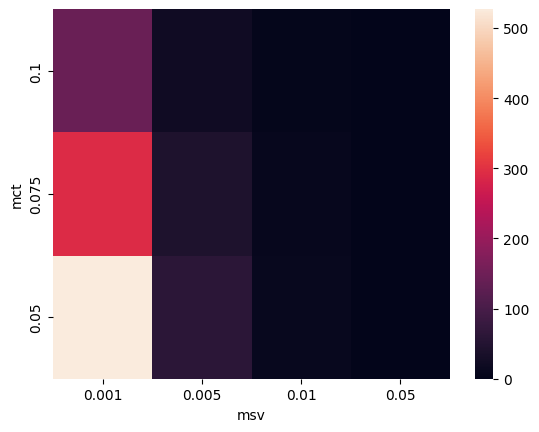

In [11]:
sns.heatmap(heatdata.sort_index(ascending=False))

**(E)**

In [12]:
frequent_itemsets_2 = apriori(df, min_support=0.005, use_colnames=True)
rules_2 = association_rules(frequent_itemsets_2, metric="confidence", min_threshold=0.0)

In [13]:
rules_2.nlargest(1,'confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
18,(frankfurter),(other vegetables),0.038125,0.12125,0.006125,0.160656,1.324996,0.001502,1.046948,0.255003


**2.Image Classification using CNN**

In [14]:
import os
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, BatchNormalization, DepthwiseConv2D, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

In [15]:
directory = "/kaggle/input/reena-dataset"

In [16]:
def images_labels(data_directory):
    Images_data = []
    labels_data = []
    classes = os.listdir(data_directory)
    for i in classes:
        for j in os.listdir(os.path.join(data_directory,i)):
            Images_data.append(os.path.join(data_directory,i,j))
            labels_data.append(i)
    return([Images_data,labels_data])

In [17]:
def data_split(data,labels,train_size):
    train_imgs,test_imgs,train_label,test_label = train_test_split(data,
                                                               labels,
                                                               train_size=train_size,
                                                               random_state=10)
    return([train_imgs,test_imgs,train_label,test_label])

In [18]:
Images_data,labels_data = images_labels(directory)
train_imgs,test_imgs,train_label,test_label = data_split(Images_data,labels_data,0.8)

In [19]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [20]:
train_data = datagen.flow_from_dataframe(
    pd.DataFrame({'file_paths': train_imgs, 'labels': train_label}),
    x_col='file_paths',
    y_col='labels',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
)

Found 527 validated image filenames belonging to 4 classes.


In [21]:
test_data = datagen.flow_from_dataframe(
    pd.DataFrame({'file_paths': test_imgs, 'labels': test_label}),
    x_col='file_paths',
    y_col='labels',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
)

Found 132 validated image filenames belonging to 4 classes.


In [22]:
cnn_1 = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])
cnn_1.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 129032)            0         
                                                                 
 dense (Dense)               (None, 16)                2064528   
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 2064820 (7.88 MB)
Trainable params: 2064820 (7.88 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [23]:
train_1 = cnn_1.fit(train_data,
                   validation_data = test_data,
                   epochs = 20)

Epoch 1/20
17/17 [==============================] - 9s 472ms/step - loss: 1.9831 - accuracy: 0.2448 - val_loss: 1.4567 - val_accuracy: 0.2424
Epoch 2/20
17/17 [==============================] - 8s 440ms/step - loss: 1.3392 - accuracy: 0.3795 - val_loss: 1.3668 - val_accuracy: 0.2652
Epoch 3/20
17/17 [==============================] - 7s 412ms/step - loss: 1.1690 - accuracy: 0.5256 - val_loss: 1.2282 - val_accuracy: 0.3939
Epoch 4/20
17/17 [==============================] - 7s 417ms/step - loss: 0.9513 - accuracy: 0.6224 - val_loss: 1.1976 - val_accuracy: 0.5152
Epoch 5/20
17/17 [==============================] - 7s 403ms/step - loss: 0.7637 - accuracy: 0.6907 - val_loss: 1.3209 - val_accuracy: 0.4773
Epoch 6/20
17/17 [==============================] - 7s 408ms/step - loss: 0.6388 - accuracy: 0.7932 - val_loss: 1.1764 - val_accuracy: 0.5909
Epoch 7/20
17/17 [==============================] - 7s 400ms/step - loss: 0.4496 - accuracy: 0.8482 - val_loss: 1.2553 - val_accuracy: 0.5076
Epoch 

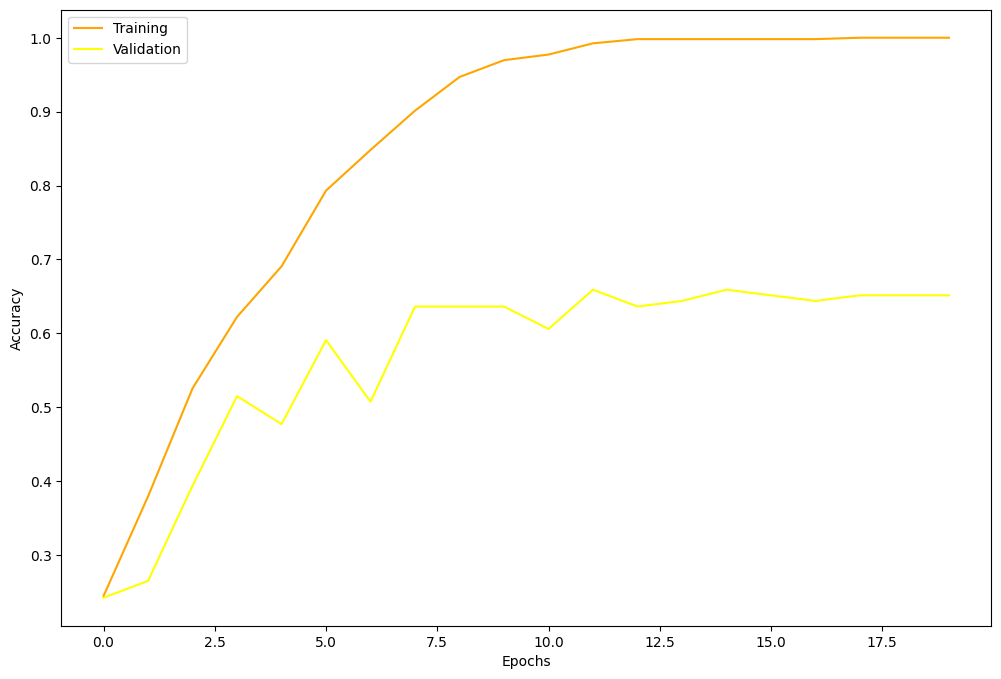

In [24]:
accuracy = train_1.history['accuracy']
val_accuracy = train_1.history['val_accuracy']

epochs = range(len(accuracy))

fig = plt.figure(figsize=(12,8))
plt.plot(epochs,accuracy,c="orange",label="Training")
plt.plot(epochs,val_accuracy,c="yellow",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

**Rowan Banner ID - 916462025**

**Hence b) Train the CNN using 2 other number of filters: 4 and 16 for the convolution layer (i) with all
other parameters unchanged**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 4)       112       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 4)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 64516)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                1032272   
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 1032452 (3.94 MB)
Trainable params: 1032452 (3.94 MB)
Non-trainable params: 0 (0.00 Byte)
________________

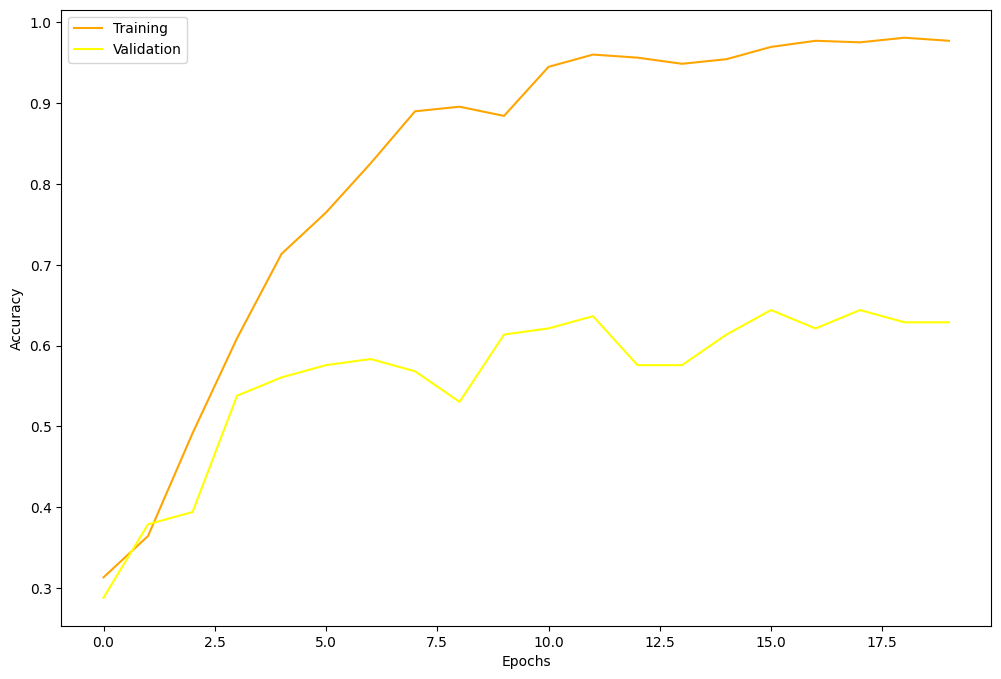

In [25]:
cnn_2 = Sequential([
    Conv2D(4, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])
cnn_2.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cnn_2.summary()

train_2 = cnn_2.fit(train_data,
                   validation_data = test_data,
                   epochs = 20)

accuracy = train_2.history['accuracy']
val_accuracy = train_2.history['val_accuracy']

epochs = range(len(accuracy))

fig = plt.figure(figsize=(12,8))
plt.plot(epochs,accuracy,c="orange",label="Training")
plt.plot(epochs,val_accuracy,c="yellow",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 258064)            0         
                                                                 
 dense_4 (Dense)             (None, 16)                4129040   
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 4129556 (15.75 MB)
Trainable params: 4129556 (15.75 MB)
Non-trainable params: 0 (0.00 Byte)
______________

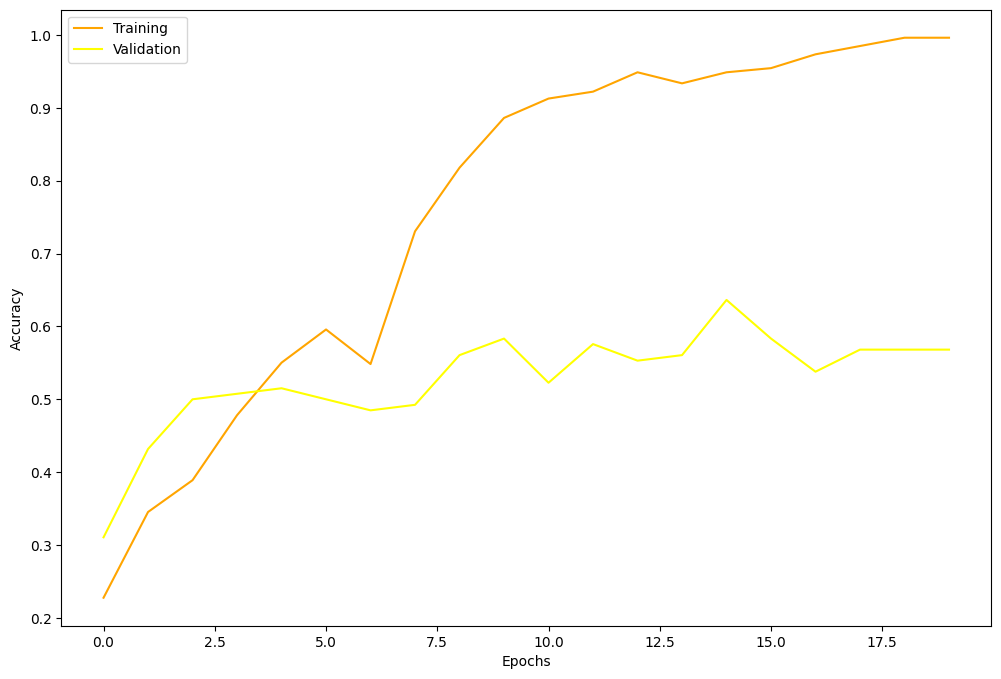

In [26]:
cnn_3 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])
cnn_3.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
cnn_3.summary()

train_3 = cnn_3.fit(train_data,
                   validation_data = test_data,
                   epochs = 20)

accuracy = train_3.history['accuracy']
val_accuracy = train_3.history['val_accuracy']

epochs = range(len(accuracy))

fig = plt.figure(figsize=(12,8))
plt.plot(epochs,accuracy,c="orange",label="Training")
plt.plot(epochs,val_accuracy,c="yellow",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

On comparing the three models' accuracy graphs, cnn_1 is mostly ideal since it has reached an stable state after certain epochs, yet training accuracy is very high compared to validation accuracy so it also might be overfitting, same goes for cnn_2 model. where as the cnn_3 model is undefitting at first and overfitting later.